# Çoklu Doğrusal Regresyon

Çoklu doğrusal regresyon bir sürekli bağımlı değişken ve iki ya da daha fazla bağımsız değişkeni tahminlememize yarar.

## Proje Senaryosu

Bu proje için küçük bir işletmenin geçmiş pazarlama promosyonu verilerini analiz edeceğiz. Her satır, işletmenin satışları artırmak için TV, sosyal medya, radyo ve influencer promosyonlarını kullandığı bağımsız bir pazarlama promosyonuna karşılık gelmektedir. 

Daha önce satışları tahmin eden tek bir değişken bulmak için çalıştılar ve şimdi bu analizi pazarlama çabalarını hedeflemelerine yardımcı olabilecek diğer değişkenleri de içerecek şekilde genişletmeyi umuyorlar.

## Peki Burada Görevimiz Nedir?

İhtiyacı karşılamak için, bağımsız değişkenlerin bir kombinasyonundan satışları tahmin etmek için çoklu doğrusal regresyon analizi yapacağız. Bu analiz, şunları içerecektir:

* **Verilerin araştırılması ve temizlenmesi**
* **Bağımsız değişkenleri seçmek için grafiklerin ve tanımlayıcı istatistiklerin kullanılması**
* **Uygun bir çoklu doğrusal regresyon modeli oluşturma**
* **Model varsayımlarının kontrol edilmesi**
* **Model çıktılarının yorumlanması ve sonuçların teknik olmayan paydaşlara iletilmesi**

## Kütüphanelerin Dahil Edilmesi

In [2]:
# 📦 Veri İşleme
import pandas as pd
import numpy as np

# 📊 Görselleştirme
import matplotlib.pyplot as plt
import seaborn as sns

# 📈 İstatistiksel Modelleme
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 📐 İstatistiksel Testler
from scipy import stats
from scipy.stats import f


In [3]:
# CSV dosyasındaki verinin okunması ve DataFrame'e dönüştürülmesi
data = pd.read_csv('marketing_sales_data.csv') 

# Verinin ilk 5 satırını görüntüleme
data.head()

,TV,Radio,Social Media,Influencer,Sales
0,Low,3.518070,2.293790,Micro,55.261284
1,Low,7.756876,2.572287,Mega,67.574904
2,High,20.348988,1.227180,Micro,272.250108
3,Medium,20.108487,2.728374,Mega,195.102176
4,High,31.653200,7.776978,Nano,273.960377


---

## Keşifsel Veri Analizi (EDA)

#### Veri Özelliklerini Tanıma

Verileri tanımak ve modellemeye hazırlamak için keşifsel bir veri analizi ile başlayalım.

Verilerdeki özellikler şunlardır:

* TV tanıtım bütçesi (“Düşük”, ‘Orta’ ve “Yüksek” kategorilerinde)
* Sosyal medya tanıtım bütçesi (milyon dolar olarak)
* Radyo tanıtım bütçesi (milyon dolar olarak)
* Satışlar (milyon dolar olarak)
* İçerik üretici büyüklüğü (“Mega”, “Makro”, ‘Mikro’ ve “Nano” kategorilerinde)

Çoklu doğrusal regresyon modeli oluşturmadan önce keşifsel veri analiziyle yapacağımız şeyler:
* Verilerde hangi değişkenlerin mevcut olduğunun anlaşılması
* Minimum, ortalama ve maksimum değerler gibi özelliklerin dağılımının gözden geçirilmesi
* Hangi özelliklerin doğrusal bir ilişkiye sahip olduğunu görselleştirmek için bağımsız ve bağımlı değişkenler arasındaki ilişkinin çizilmesi
* Yanlış değerler (örn. yazım hataları) veya eksik değerler gibi verilerle ilgili sorunların belirlenmesi

<Axes: xlabel='TV', ylabel='Sales'>

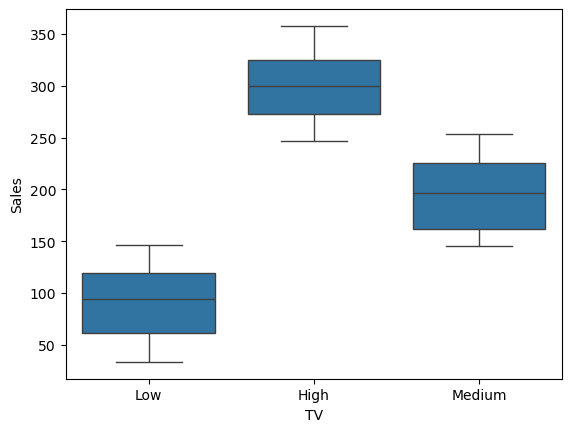

In [4]:
# TV ve Sales sütunlarının kutu grafiğini çizme
sns.boxplot(x = "TV", y = "Sales", data = data)

<Axes: xlabel='Influencer', ylabel='Sales'>

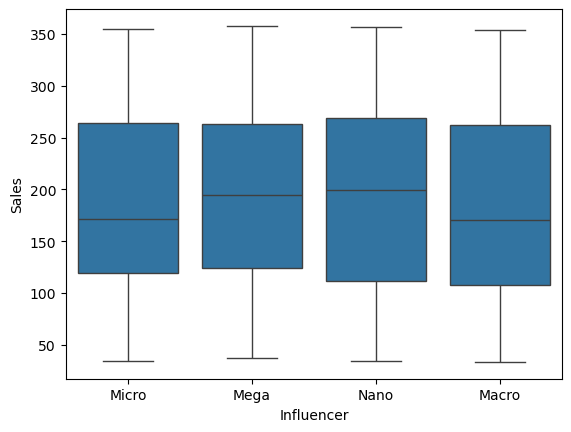

In [5]:
# Influencer ve Sales sütunlarının kutu grafiğini çizme
sns.boxplot(x = "Influencer", y = "Sales", data = data)

### Pairplot'un Oluşturulması

Veri`deki sürekli değişkenler arasındaki ilişkiyi görselleştirmek için bir pairplot oluşturalım.

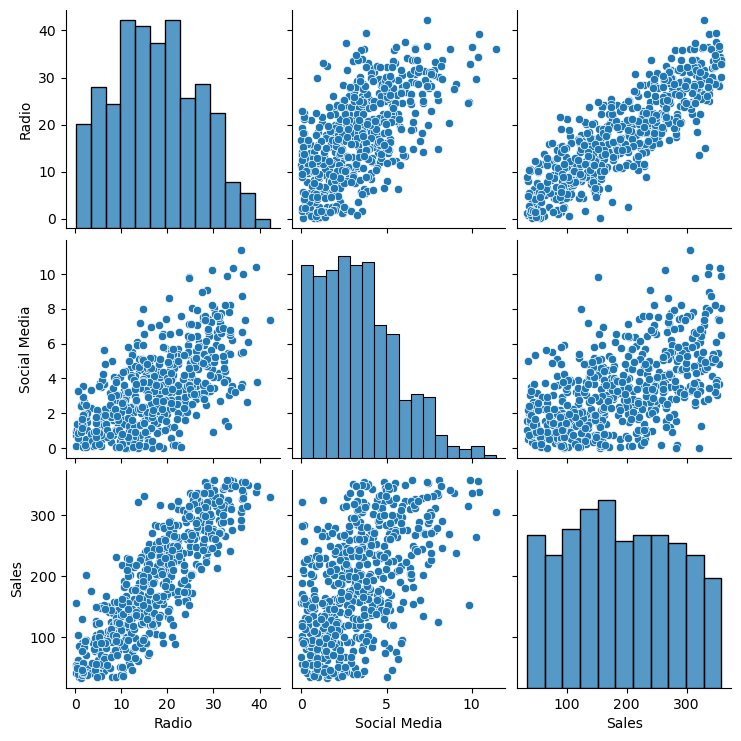

In [6]:
sns.pairplot(data)

In [7]:
# Veride herhangi bir eksik değer bulunmamaktadır.
print(data.isnull().sum(axis=0))

TV              0
Radio           0
Social Media    0
Influencer      0
Sales           0
dtype: int64


### Her kategorik değişken için ortalama satışların incelenmesi

In [8]:
# Her TV veri kategorisi için ortalama satışların hesaplanması 
print(data.groupby('TV')['Sales'].mean())

print('')

# Her Influencer veri kategorisi için ortalama satışların hesaplanması
print(data.groupby('Influencer')['Sales'].mean())

TV
High      300.853195
Low        90.984101
Medium    195.358032
Name: Sales, dtype: float64

Influencer
Macro    181.670070
Mega     194.487941
Micro    188.321846
Nano     191.874432
Name: Sales, dtype: float64


`High` düzeyindeki TV verisi `Low` ve `Medium` düzeylerine göre ortalama satış bakımından oldukça fazladır.

`TV` değişkeni `Sales` bağımlı değişkeni için önemli bir tahminci olabilir. 

`Influencer` değişkeninin kategorileri farklı ortalama `Sales` verisine sahiptir. Bu kategoriler bazında ortalama `Sales` verisi birbirinden çok farklı olmadığından bu değişken zayıf bir tahminci olabilir, modele katkısı çok olmayabilir. 

Bu sonuçlar, çoklu doğrusal regresyon modeli kurulduğunda daha ayrıntılı olarak incelenebilir.

---

## Değişken Dönüşümleri

`ols()` fonksiyonu, değişken isimleri boşluk içerdiğinde çalışmaz. Bu nedenle boşluk içeren `Social Media` değişkeninin ismini düzeltelim.

In [9]:
data = data.rename(columns={'Social Media': 'Social_Media'})

`TV` ve `Influencer` sütunları sıralı (ordinal) olduğu için, bu sütunları sayısal değerlere dönüştüreceğiz.


In [10]:
print(data['TV'].unique())
print("")
print(data['Influencer'].unique())

['Low' 'High' 'Medium']

['Micro' 'Mega' 'Nano' 'Macro']


In [ ]:
# TV sütunundaki kategorik verilerin ordinal hale getirilmesi
ordinal_mapping = {'Low': 0, 'Medium': 1, 'High': 2}

data['TV'] = data['TV'].map(ordinal_mapping)

In [ ]:
# Influencer sütunundaki kategorik verilerin ordinal hale getirilmesi
ordinal_mapping = {'Nano': 0, 'Micro': 1, 'Macro': 2, 'Mega': 3}

data['Influencer'] = data['Influencer'].map(ordinal_mapping)

In [ ]:
data.head()

---

## Model Kurma Aşaması

#### Satışları tahmin eden bir çoklu doğrusal regresyon modeli kuralım

$$
\text{Basit Doğrusal Regresyon Formülü: }y=\beta_{0}+\beta_{1}X_{1}+\varepsilon_{i}\newline\newline
$$

$$
\text{En Küçük Kareler Yöntemiyle Basit Doğrusal Regresyon Çözümü:}\newline
\beta_{0}=\bar{y} - \beta_{1}\bar{X}
$$
$$
\beta_{1}=\frac{\sum_{i=1}^{m}(X_{i}-\bar{X})*(Y_{i}-\bar{Y})}{\sum_{i=1}^{m}(X_{i}-\bar{X})^{2}}
$$

$$
\text{En Küçük Kareler Yönteminin Doğrusal Cebir Formu:}\newline
\hat{\boldsymbol{\beta}} = (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{y}
$$


In [11]:
# Modeldeki bağımlı ve bağımsız değişkenleri belirleyelim:
ols_formula = 'Sales ~ TV + Radio + Social_Media + Influencer'

# OLS modelini tanımlayalım ve veriyi kullanarak katsayıları elde edelim.
OLS = ols(formula = ols_formula, data = data) 
model = OLS.fit()
model_results = model.summary() # Model sonuçlarının kaydedilmesi
print(model_results)

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     760.4
Date:                Fri, 13 Jun 2025   Prob (F-statistic):          1.82e-282
Time:                        20:47:16   Log-Likelihood:                -2713.4
No. Observations:                 572   AIC:                             5443.
Df Residuals:                     564   BIC:                             5478.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             217.4784    

In [12]:
data.drop(columns=['Social_Media', 'Influencer'], inplace=True)

* Regresyon sonuçları, `TV`'nin `Sales` üzerinde çok güçlü ve istatistiksel olarak anlamlı bir pozitif etkisi olduğunu gösterdiği için `TV` seçildi.
* `Radio`, regresyon analizine göre `Sales` ile anlamlı ve pozitif bir ilişki gösterdiği için seçildi.
* `Social Media`, `Sales` üzerinde istatistiksel olarak anlamlı bir etkisi olmadığı ve p-değeri yüksek olduğu için seçilmedi.
* `Influencer`, `Sales` ile anlamlı bir ilişki göstermediği ve modeli iyileştirmediği için seçilmedi.